## Problem Statement

The goal of this project is to see what classifiers work best in predicting heart attacks. The data will be preprocessed and anomaly detection will be used to find outliers and remove them. Then, a compressed version of the dataset, through Principal Component Analysis, to see if data compression will improve performance. Then, each of those data sets will be used in several classification methods to see which one will perform the best for the dataset. Those classifiers will be compared using f1-score, accuracy and run time. The classifiers will also be tuned before a decision is made.

Principal Component Analysis (PCA) will be used on the dataset to produce a
compressed version of the dataset. The compressed dataset will be compared
to the regular dataset to see whether using PCA will improve the performance of the classifiers.
The classification methods that will be used are listed below.
1. Logistical Regression
2. Linear Discriminant Analysis (LDA)
3. Quadrantic Discriminant Analysis (QDA)
4. Decision Tree Classifier.
5. Random Forest Classifier
6. XGBoost Classifier

The best classifier will be chosen based on F1-score, accuracy and classification run time.

https://www.kaggle.com/ronitf/heart-disease-uci

In [ ]:
import numpy as np # data manipulation
import pandas as pd # data manipulation
import copy
import seaborn as sn
import time # for timing
import matplotlib.pyplot as plt # plotting
import io # for importing data
from google.colab import files # upload files

from sklearn.preprocessing import scale # preprocessing
from sklearn.inspection import permutation_importance # feature importance
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split # to split into training and testing

# classifiers
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.linear_model import LogisticRegressionCV # logistic regression cross-validation tuning
from sklearn.neighbors import KNeighborsClassifier # knn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis # QDA
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import RandomForestClassifier # random forest
from xgboost import XGBClassifier # xgboost
from sklearn.model_selection import GridSearchCV # hyperparameter tuning method

# decision metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## Preprocessing


In [ ]:
uploaded = files.upload()
DATA = pd.read_csv(io.BytesIO(uploaded['heart.csv']))
DATA

Saving heart.csv to heart (1).csv


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [ ]:
# split up data into 
X = DATA.drop(['target'], axis=1)
names = X.columns
X = X.to_numpy()
Y = DATA['target'].to_numpy()

## Dimensionality Reduction

### Principal Component Analysis

In [ ]:
# Principal component analysis
def PCA(X, alpha):        
    # find the original dimension and print it
    dimension = X.shape[1]
    print('The original dimension of the data is', dimension)
    
    # center D to have mean 0
    X -= np.mean(X, axis=0)
    
    # compute the covariance matrix
    Sigma = (1/X.shape[0]) * X.T @ X

    # compute the eigenvalues and eigenvectors of D^T D
    (eValues, eVectors) = np.linalg.eigh(Sigma)

    # compute the total variance
    varX = np.sum(eValues)
    
    # initialize the variance for A to 0
    varA = 0.0
    
    # reverse eValues and eVectors
    eValues = np.flip(eValues)
    eVectors = np.flip(eVectors, axis=1)

    # find the minimum dimension consisting of fraction at least alpha of the total variance
    for r in np.arange(0, eValues.shape[0]):
        varA += eValues[r]
        ratio = varA/varX

        if ratio > alpha:
            dimension = r + 1
            print('The new dimension of the data is', dimension, 'and it explains', ratio, 'of the variance')
            break
            
    # construct the new basis
    basis = eVectors[:,:dimension]
    
    # create the datapoints in the new space
    A = X @ basis
    
    # return points
    return A

In [ ]:
start = time.time()

# Apply PCA to the data
X_pca = PCA(X, 0.8)

end = time.time()
print('PCA took', end-start, 'seconds')

The original dimension of the data is 13
The new dimension of the data is 2 and it explains 0.8979344199759483 of the variance
PCA took 0.010816097259521484 seconds


### t-distributed Stochastic Neighbor Embedding (tSNE)

In [ ]:
start = time.time()

# Apply PCA to the data
X_tsne = TSNE(n_components = 3).fit_transform(X)

end = time.time()
print('tSNE took', end-start, 'seconds')

tSNE took 8.519102334976196 seconds


## Classification Methods and Hyperparameter Tuning

### Logistic Regression

Tuning Logistic Regression Model took 0.06998920440673828 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.85      0.78      0.81        59
           1       0.81      0.87      0.84        63

    accuracy                           0.83       122
   macro avg       0.83      0.83      0.83       122
weighted avg       0.83      0.83      0.83       122


Confusion Matrix:



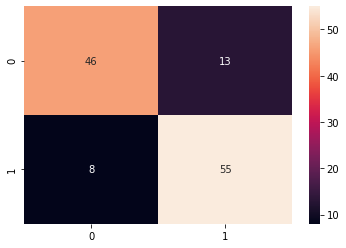

In [ ]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time() # time how long it takes to find the model

# create model
model_lr = LogisticRegression(C = 2, max_iter = 10000)
model_lr.fit(trainX, trainY)

end = time.time()
print('Tuning Logistic Regression Model took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_lr.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Tuning Logistic Regression Model took 0.0071375370025634766 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.70      0.54      0.61        59
           1       0.64      0.78      0.71        63

    accuracy                           0.66       122
   macro avg       0.67      0.66      0.66       122
weighted avg       0.67      0.66      0.66       122


Confusion Matrix:



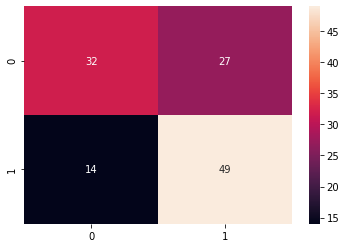

In [ ]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

start = time.time() # time how long it takes to find the model

# create model
model_lr = LogisticRegression(C = 2, max_iter = 10000)
model_lr.fit(trainX, trainY)

end = time.time()
print('Tuning Logistic Regression Model took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_lr.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Tuning Logistic Regression Model took 0.010828733444213867 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.68      0.42      0.52        59
           1       0.60      0.81      0.69        63

    accuracy                           0.62       122
   macro avg       0.64      0.62      0.61       122
weighted avg       0.64      0.62      0.61       122


Confusion Matrix:



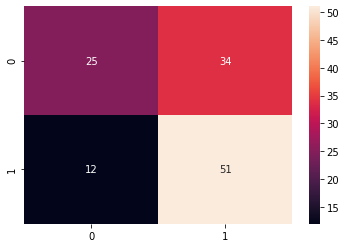

In [ ]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time() # time how long it takes to find the model

# create model
model_lr = LogisticRegression(C = 2, max_iter = 10000)
model_lr.fit(trainX, trainY)

end = time.time()
print('Tuning Logistic Regression Model took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_lr.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Tuning Logistic Regression Model took 1.9113693237304688 seconds
Grid search chose the C value of [2.11315789]

Classification Report:

               precision    recall  f1-score   support

           0       0.85      0.78      0.81        59
           1       0.81      0.87      0.84        63

    accuracy                           0.83       122
   macro avg       0.83      0.83      0.83       122
weighted avg       0.83      0.83      0.83       122


Confusion Matrix:



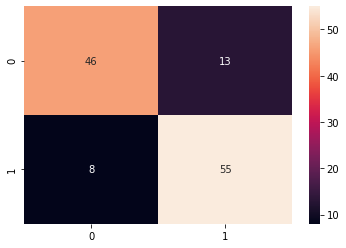

In [ ]:
# hyperparameter values
cValues = np.linspace(0.01, 10, 20)

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time() # time how long it takes to find the model

# create model
model_lr = LogisticRegressionCV(Cs = cValues, cv = 5, max_iter = 10000)
model_lr.fit(trainX, trainY)

end = time.time()
print('Tuning Logistic Regression Model took', end - start, 'seconds')

# find best hyperparameter value
bestC_original = model_lr.C_
print('Grid search chose the C value of', bestC_original)

# predict the labels of the test set
predictedY = model_lr.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Tuning Logistic Regression Model took 0.18212532997131348 seconds
Grid search chose the C value of [0.01]

Classification Report:

               precision    recall  f1-score   support

           0       0.70      0.54      0.61        59
           1       0.64      0.78      0.71        63

    accuracy                           0.66       122
   macro avg       0.67      0.66      0.66       122
weighted avg       0.67      0.66      0.66       122


Confusion Matrix:



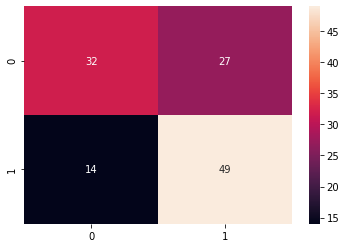

In [ ]:
# hyperparameter values
cValues = np.linspace(0.01, 10, 20)

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

start = time.time()

# create model
model_lr = LogisticRegressionCV(Cs = cValues, cv = 5, max_iter = 10000)
model_lr.fit(trainX, trainY)

end = time.time()
print('Tuning Logistic Regression Model took', end - start, 'seconds')

# find best hyperparameter value
bestC_pca = model_lr.C_
print('Grid search chose the C value of', bestC_pca)

# predict the labels of the test set
predictedY = model_lr.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Tuning Logistic Regression Model took 0.16268205642700195 seconds
Grid search chose the C value of [0.01]

Classification Report:

               precision    recall  f1-score   support

           0       0.68      0.42      0.52        59
           1       0.60      0.81      0.69        63

    accuracy                           0.62       122
   macro avg       0.64      0.62      0.61       122
weighted avg       0.64      0.62      0.61       122


Confusion Matrix:



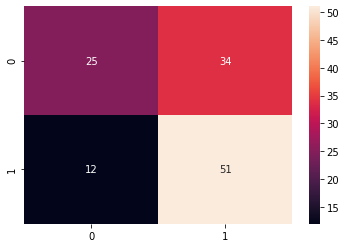

In [ ]:
# hyperparameter values
cValues = np.linspace(0.01, 10, 20)

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time()

# create model
model_lr = LogisticRegressionCV(Cs = cValues, cv = 5, max_iter = 10000)
model_lr.fit(trainX, trainY)

end = time.time()
print('Tuning Logistic Regression Model took', end - start, 'seconds')

# find best hyperparameter value
bestC_tsne = model_lr.C_
print('Grid search chose the C value of', bestC_pca)

# predict the labels of the test set
predictedY = model_lr.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

### k-Nearest Neighbor Classifier


Classification Report:

               precision    recall  f1-score   support

           0       0.65      0.61      0.63        59
           1       0.66      0.70      0.68        63

    accuracy                           0.66       122
   macro avg       0.66      0.65      0.65       122
weighted avg       0.66      0.66      0.65       122


Test Confusion Matrix:



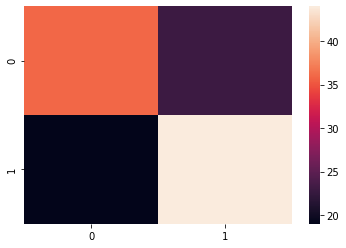

In [ ]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

# build the knn classifier
model_knn = KNeighborsClassifier(3)

# fit the knn classifier to the training data
model_knn.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_knn.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nTest Confusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY))


Classification Report:

               precision    recall  f1-score   support

           0       0.62      0.58      0.60        59
           1       0.63      0.67      0.65        63

    accuracy                           0.62       122
   macro avg       0.62      0.62      0.62       122
weighted avg       0.62      0.62      0.62       122


Test Confusion Matrix:



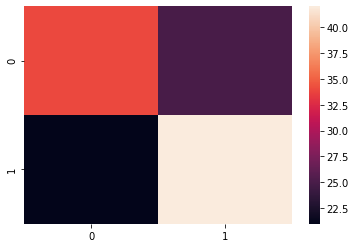

In [ ]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

# build the knn classifier
model_knn = KNeighborsClassifier(3)

# fit the knn classifier to the training data
model_knn.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_knn.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nTest Confusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY))


Classification Report:

               precision    recall  f1-score   support

           0       0.53      0.51      0.52        59
           1       0.55      0.57      0.56        63

    accuracy                           0.54       122
   macro avg       0.54      0.54      0.54       122
weighted avg       0.54      0.54      0.54       122


Test Confusion Matrix:



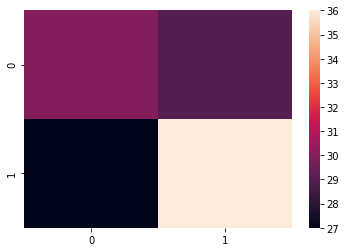

In [ ]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

# build the knn classifier
model_knn = KNeighborsClassifier(3)

# fit the knn classifier to the training data
model_knn.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_knn.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nTest Confusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY))

Mean CV accuracy for 1 neighbors is 0.5638138138138139
Mean CV accuracy for 2 neighbors is 0.5632132132132133
Mean CV accuracy for 3 neighbors is 0.6241741741741741
Mean CV accuracy for 4 neighbors is 0.5968468468468469
Mean CV accuracy for 5 neighbors is 0.6078078078078077
Mean CV accuracy for 6 neighbors is 0.6246246246246246
Mean CV accuracy for 7 neighbors is 0.6133633633633633
Mean CV accuracy for 8 neighbors is 0.6243243243243243
Mean CV accuracy for 9 neighbors is 0.6076576576576576
Mean CV accuracy for 10 neighbors is 0.6132132132132133

The best dev accuracy 0.6246246246246246 occured with 6 neghbors

Test Classification Report for 0.6246246246246246 neighbors:

               precision    recall  f1-score   support

           0       0.68      0.68      0.68        59
           1       0.70      0.70      0.70        63

    accuracy                           0.69       122
   macro avg       0.69      0.69      0.69       122
weighted avg       0.69      0.69      0.69    

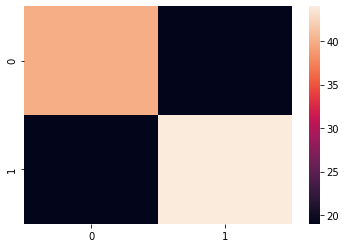

In [ ]:
bestAccuracy_o = [0, 0]

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

for k in range(1, 11):
    # build the knn classifier
    model_knn = KNeighborsClassifier(k)

    # fit the knn classifier to the training data
    model_knn.fit(trainX, trainY)
    
    mean_cv_scores = np.mean(cross_val_score(model_knn, trainX, trainY, cv = 5))

    # print quality metrics
    print('Mean CV accuracy for', k, 'neighbors is', mean_cv_scores)
    
    # save the hyperparameter k if better than found before
    if mean_cv_scores > bestAccuracy_o[0]:
        bestAccuracy_o = [mean_cv_scores, k]
        
print('\nThe best dev accuracy', bestAccuracy_o[0], 'occured with', bestAccuracy_o[1], 'neghbors')
        
# build the knn classifier
model_knn = KNeighborsClassifier(bestAccuracy_o[1])

# fit the knn classifier to the training data
model_knn.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_knn.predict(testX)

# print quality metrics
print('\nTest Classification Report for', bestAccuracy_o[0], 'neighbors:\n\n', classification_report(testY, predictedY))
print('\nTest Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))

Mean CV accuracy for 1 neighbors is 0.508108108108108
Mean CV accuracy for 2 neighbors is 0.5472972972972974
Mean CV accuracy for 3 neighbors is 0.5857357357357358
Mean CV accuracy for 4 neighbors is 0.5752252252252252
Mean CV accuracy for 5 neighbors is 0.6028528528528528
Mean CV accuracy for 6 neighbors is 0.6028528528528528
Mean CV accuracy for 7 neighbors is 0.5971471471471472
Mean CV accuracy for 8 neighbors is 0.6081081081081081
Mean CV accuracy for 9 neighbors is 0.6136636636636638
Mean CV accuracy for 10 neighbors is 0.6135135135135135

The best dev accuracy 0.6136636636636638 occured with 9 neghbors

Test Classification Report for 0.6136636636636638 neighbors:

               precision    recall  f1-score   support

           0       0.65      0.58      0.61        59
           1       0.64      0.71      0.68        63

    accuracy                           0.65       122
   macro avg       0.65      0.65      0.64       122
weighted avg       0.65      0.65      0.65     

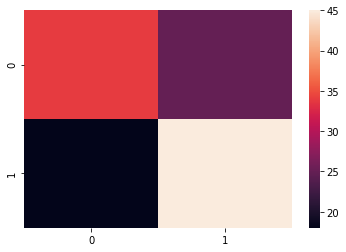

In [ ]:
bestAccuracy_pca = [0, 0]

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

for k in range(1, 11):
    # build the knn classifier
    model_knn = KNeighborsClassifier(k)

    # fit the knn classifier to the training data
    model_knn.fit(trainX, trainY)
    
    mean_cv_scores = np.mean(cross_val_score(model_knn, trainX, trainY, cv = 5))

    # print quality metrics
    print('Mean CV accuracy for', k, 'neighbors is', mean_cv_scores)
    
    # save the hyperparameter k if better than found before
    if mean_cv_scores > bestAccuracy_pca[0]:
        bestAccuracy_pca = [mean_cv_scores, k]
        
print('\nThe best dev accuracy', bestAccuracy_pca[0], 'occured with', bestAccuracy_pca[1], 'neghbors')
        
# build the knn classifier
model_knn = KNeighborsClassifier(bestAccuracy_pca[1])

# fit the knn classifier to the training data
model_knn.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_knn.predict(testX)

# print quality metrics
print('\nTest Classification Report for', bestAccuracy_pca[0], 'neighbors:\n\n', classification_report(testY, predictedY))
print('\nTest Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))

Mean CV accuracy for 1 neighbors is 0.6078078078078077
Mean CV accuracy for 2 neighbors is 0.5247747747747747
Mean CV accuracy for 3 neighbors is 0.5693693693693694
Mean CV accuracy for 4 neighbors is 0.5638138138138138
Mean CV accuracy for 5 neighbors is 0.590990990990991
Mean CV accuracy for 6 neighbors is 0.5692192192192193
Mean CV accuracy for 7 neighbors is 0.5744744744744745
Mean CV accuracy for 8 neighbors is 0.5801801801801801
Mean CV accuracy for 9 neighbors is 0.5636636636636637
Mean CV accuracy for 10 neighbors is 0.5803303303303303

The best dev accuracy 0.6078078078078077 occured with 1 neghbors

Test Classification Report for 0.6078078078078077 neighbors:

               precision    recall  f1-score   support

           0       0.55      0.56      0.55        59
           1       0.58      0.57      0.58        63

    accuracy                           0.57       122
   macro avg       0.57      0.57      0.57       122
weighted avg       0.57      0.57      0.57     

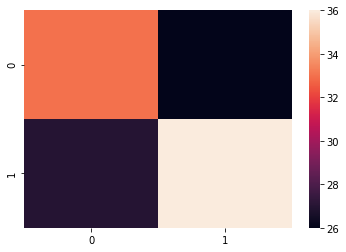

In [ ]:
bestAccuracy_tsne = [0, 0]

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

for k in range(1, 11):
    # build the knn classifier
    model_knn = KNeighborsClassifier(k)

    # fit the knn classifier to the training data
    model_knn.fit(trainX, trainY)
    
    mean_cv_scores = np.mean(cross_val_score(model_knn, trainX, trainY, cv = 5))

    # print quality metrics
    print('Mean CV accuracy for', k, 'neighbors is', mean_cv_scores)
    
    # save the hyperparameter k if better than found before
    if mean_cv_scores > bestAccuracy_tsne[0]:
        bestAccuracy_tsne = [mean_cv_scores, k]
        
print('\nThe best dev accuracy', bestAccuracy_tsne[0], 'occured with', bestAccuracy_tsne[1], 'neghbors')
        
# build the knn classifier
model_knn = KNeighborsClassifier(bestAccuracy_tsne[1])

# fit the knn classifier to the training data
model_knn.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_knn.predict(testX)

# print quality metrics
print('\nTest Classification Report for', bestAccuracy_tsne[0], 'neighbors:\n\n', classification_report(testY, predictedY))
print('\nTest Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))

### Linear Discriminant Analysis (LDA)

Running LDA took 0.002537250518798828 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.85      0.69      0.77        59
           1       0.76      0.89      0.82        63

    accuracy                           0.80       122
   macro avg       0.81      0.79      0.79       122
weighted avg       0.80      0.80      0.79       122


Confusion Matrix:



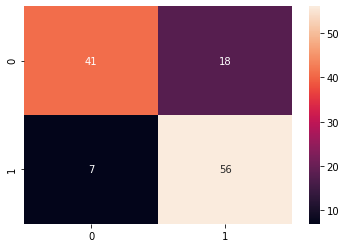

In [ ]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build the LDA classifier
model_lda = LinearDiscriminantAnalysis()

# fit the LDA classifier to the training data
model_lda.fit(trainX, trainY)

end = time.time()
print('Running LDA took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_lda.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Running LDA took 0.0015387535095214844 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.69      0.53      0.60        59
           1       0.64      0.78      0.70        63

    accuracy                           0.66       122
   macro avg       0.66      0.65      0.65       122
weighted avg       0.66      0.66      0.65       122


Confusion Matrix:



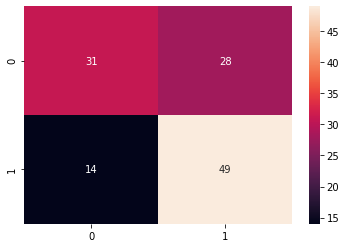

In [ ]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build the LDA classifier
model_lda = LinearDiscriminantAnalysis()

# fit the LDA classifier to the training data
model_lda.fit(trainX, trainY)

end = time.time()
print('Running LDA took', end - start, 'seconds')

# find the mean cross-validation accuracy
mean_cv_scores = np.mean(cross_val_score(model_lda, trainX, trainY, cv = 5))

# predict the labels of the test set
predictedY = model_lda.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Running LDA took 0.002650022506713867 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.66      0.39      0.49        59
           1       0.59      0.81      0.68        63

    accuracy                           0.61       122
   macro avg       0.62      0.60      0.58       122
weighted avg       0.62      0.61      0.59       122


Confusion Matrix:



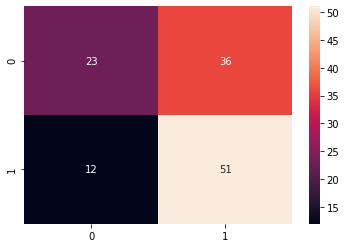

In [ ]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build the LDA classifier
model_lda = LinearDiscriminantAnalysis()

# fit the LDA classifier to the training data
model_lda.fit(trainX, trainY)

end = time.time()
print('Running LDA took', end - start, 'seconds')

# find the mean cross-validation accuracy
mean_cv_scores = np.mean(cross_val_score(model_lda, trainX, trainY, cv = 5))

# predict the labels of the test set
predictedY = model_lda.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

### Quadrantic Discriminant Analysis (QDA)

Running QDA took 0.006155967712402344 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.82      0.69      0.75        59
           1       0.75      0.86      0.80        63

    accuracy                           0.78       122
   macro avg       0.78      0.78      0.78       122
weighted avg       0.78      0.78      0.78       122


Confusion Matrix:



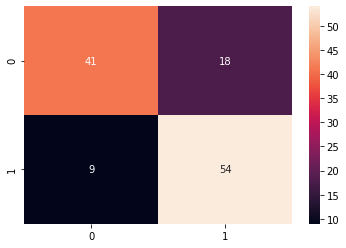

In [ ]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build the LDA classifier
model_qda = QuadraticDiscriminantAnalysis(reg_param = 0.5)

# fit the LDA classifier to the training data
model_qda.fit(trainX, trainY)

end = time.time()
print('Running QDA took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_qda.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Running QDA took 0.0015482902526855469 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.70      0.59      0.64        59
           1       0.67      0.76      0.71        63

    accuracy                           0.68       122
   macro avg       0.68      0.68      0.68       122
weighted avg       0.68      0.68      0.68       122


Confusion Matrix:



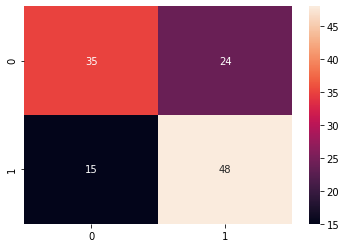

In [ ]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build the LDA classifier
model_qda = QuadraticDiscriminantAnalysis(reg_param = 0.5)

# fit the LDA classifier to the training data
model_qda.fit(trainX, trainY)

end = time.time()
print('Running QDA took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_qda.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Running QDA took 0.0017271041870117188 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.65      0.41      0.50        59
           1       0.59      0.79      0.68        63

    accuracy                           0.61       122
   macro avg       0.62      0.60      0.59       122
weighted avg       0.62      0.61      0.59       122


Confusion Matrix:



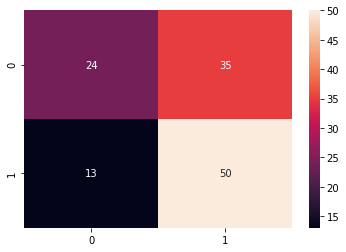

In [ ]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build the LDA classifier
model_qda = QuadraticDiscriminantAnalysis(reg_param = 0.5)

# fit the LDA classifier to the training data
model_qda.fit(trainX, trainY)

end = time.time()
print('Running QDA took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_qda.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Tuning QDA took 0.3112170696258545 seconds

The best dev accuracy 0.8402402402402401 occured with 0.07 regularization parameter

Test Classification Report for 0.6246246246246246 reg_param:

               precision    recall  f1-score   support

           0       0.86      0.71      0.78        59
           1       0.77      0.89      0.82        63

    accuracy                           0.80       122
   macro avg       0.81      0.80      0.80       122
weighted avg       0.81      0.80      0.80       122


Confusion Matrix:



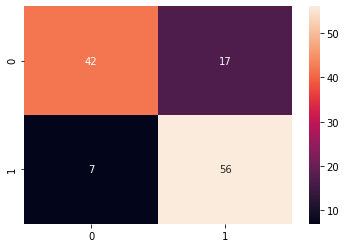

In [ ]:
bestAccuracy_qda_o = [0, 0]

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time()

# test hyperparameters
for i in range(25):
    rp = i/100
    
    # build the QDA classifier
    model_qda = QuadraticDiscriminantAnalysis(reg_param = rp)

    # fit the QDA classifier to the training data
    model_qda.fit(trainX, trainY)
    
    # find the mean cross-validation accuracy
    mean_cv_scores = np.mean(cross_val_score(model_qda, trainX, trainY, cv = 5))
    
    # save the hyperparameter reg_param if better than found before
    if mean_cv_scores > bestAccuracy_qda_o[0]:
        bestAccuracy_qda_o = [mean_cv_scores, rp]
        
end = time.time()
print('Tuning QDA took', end - start, 'seconds')

print('\nThe best dev accuracy', bestAccuracy_qda_o[0], 'occured with', bestAccuracy_qda_o[1], 'regularization parameter')
        
# build the QDA classifier
model_qda = QuadraticDiscriminantAnalysis(reg_param = bestAccuracy_qda_o[1])

# fit the QDA classifier to the training data
model_qda.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_qda.predict(testX)

# print quality metrics
print('\nTest Classification Report for', bestAccuracy[0], 'reg_param:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Tuning QDA took 0.20762968063354492 seconds

The best dev accuracy 0.7237237237237237 occured with 0.24 regularization parameter

Test Classification Report for 0.7237237237237237 reg_param:

               precision    recall  f1-score   support

           0       0.70      0.59      0.64        59
           1       0.67      0.76      0.71        63

    accuracy                           0.68       122
   macro avg       0.68      0.68      0.68       122
weighted avg       0.68      0.68      0.68       122


Confusion Matrix:



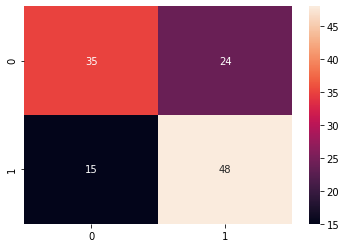

In [ ]:
bestAccuracy_qda_pca = [0, 0]

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

start = time.time()

# test hyperparameters
for i in range(25):
    rp = i/100
    
    # build the QDA classifier
    model_qda = QuadraticDiscriminantAnalysis(reg_param = rp)

    # fit the QDA classifier to the training data
    model_qda.fit(trainX, trainY)
    
    # find the mean cross-validation accuracy
    mean_cv_scores = np.mean(cross_val_score(model_qda, trainX, trainY, cv = 5))
    
    # save the hyperparameter reg_param if better than found before
    if mean_cv_scores > bestAccuracy_qda_pca[0]:
        bestAccuracy_qda_pca = [mean_cv_scores, rp]
        
end = time.time()
print('Tuning QDA took', end - start, 'seconds')

print('\nThe best dev accuracy', bestAccuracy_qda_pca[0], 'occured with', bestAccuracy_qda_pca[1], 'regularization parameter')
        
# build the QDA classifier
model_qda = QuadraticDiscriminantAnalysis(reg_param = bestAccuracy_qda_pca[1])

# fit the QDA classifier to the training data
model_qda.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_qda.predict(testX)

# print quality metrics
print('\nTest Classification Report for', bestAccuracy_qda_pca[0], 'reg_param:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Tuning QDA took 0.22359323501586914 seconds

The best dev accuracy 0.5471471471471471 occured with 0.06 regularization parameter

Test Classification Report for 0.5471471471471471 reg_param:

               precision    recall  f1-score   support

           0       0.62      0.53      0.57        59
           1       0.61      0.70      0.65        63

    accuracy                           0.61       122
   macro avg       0.62      0.61      0.61       122
weighted avg       0.62      0.61      0.61       122


Confusion Matrix:



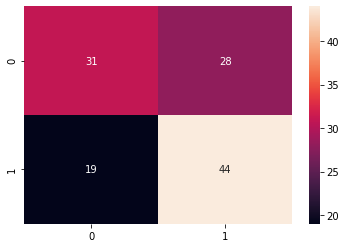

In [ ]:
bestAccuracy_qda_tsne = [0, 0]

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time()

# test hyperparameters
for i in range(25):
    rp = i/100
    
    # build the QDA classifier
    model_qda = QuadraticDiscriminantAnalysis(reg_param = rp)

    # fit the QDA classifier to the training data
    model_qda.fit(trainX, trainY)
    
    # find the mean cross-validation accuracy
    mean_cv_scores = np.mean(cross_val_score(model_qda, trainX, trainY, cv = 5))
    
    # save the hyperparameter reg_param if better than found before
    if mean_cv_scores > bestAccuracy_qda_tsne[0]:
        bestAccuracy_qda_tsne = [mean_cv_scores, rp]
        
end = time.time()
print('Tuning QDA took', end - start, 'seconds')

print('\nThe best dev accuracy', bestAccuracy_qda_tsne[0], 'occured with', bestAccuracy_qda_tsne[1], 'regularization parameter')
        
# build the QDA classifier
model_qda = QuadraticDiscriminantAnalysis(reg_param = bestAccuracy_qda_tsne[1])

# fit the QDA classifier to the training data
model_qda.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_qda.predict(testX)

# print quality metrics
print('\nTest Classification Report for', bestAccuracy_qda_tsne[0], 'reg_param:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

### Decision Tree Classifier

Tuning Decision Tree Classifier took 0.0033676624298095703 seconds

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.75      0.81      0.78        59
           1       0.81      0.75      0.78        63

    accuracy                           0.78       122
   macro avg       0.78      0.78      0.78       122
weighted avg       0.78      0.78      0.78       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

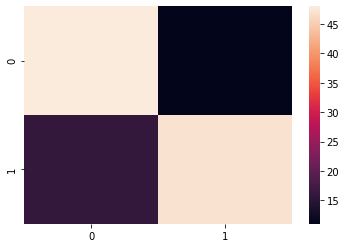

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
model_dt = DecisionTreeClassifier()

# fit the classifier to the training data
model_dt.fit(trainX, trainY)

end = time.time()
print('Tuning Decision Tree Classifier took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_dt.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Tuning Decision Tree Classifier took 0.0027844905853271484 seconds

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.62      0.56      0.59        59
           1       0.62      0.68      0.65        63

    accuracy                           0.62       122
   macro avg       0.62      0.62      0.62       122
weighted avg       0.62      0.62      0.62       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

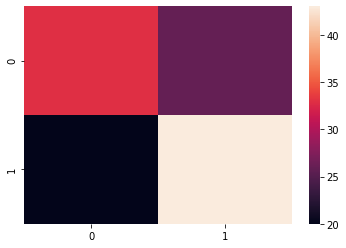

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
model_dt = DecisionTreeClassifier()

# fit the classifier to the training data
model_dt.fit(trainX, trainY)

end = time.time()
print('Tuning Decision Tree Classifier took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_dt.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Tuning Decision Tree Classifier took 0.0011246204376220703 seconds

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.55      0.51      0.53        59
           1       0.57      0.60      0.58        63

    accuracy                           0.56       122
   macro avg       0.56      0.56      0.56       122
weighted avg       0.56      0.56      0.56       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

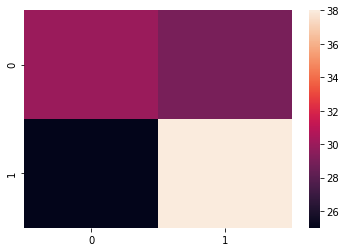

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
model_dt = DecisionTreeClassifier()

# fit the classifier to the training data
model_dt.fit(trainX, trainY)

end = time.time()
print('Tuning Decision Tree Classifier took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_dt.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Tuning Decision Tree Classifier took 0.18519878387451172 seconds
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.78      0.61      0.69        59
           1       0.70      0.84      0.76        63

    accuracy                           0.73       122
   macro avg       0.74      0.73      0.72       122
weighted avg       0.74      0.73      0.73       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

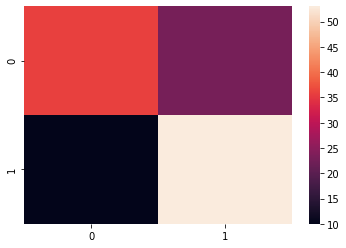

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
parameters = {'max_depth': [1, 5, 10, 100, None], 'max_features': [2, 3, 4]}
model_dt = GridSearchCV(DecisionTreeClassifier(), param_grid = parameters, cv = 5, n_jobs = -1)

# fit the classifier to the training data
model_dt.fit(trainX, trainY)

end = time.time()
print('Tuning Decision Tree Classifier took', end - start, 'seconds')

# find best hyperparameters
print(model_dt.best_estimator_)

# predict the labels of the test set
predictedY = model_dt.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

In [ ]:
bestDepth_DT_original = 10
bestMaxFeatures_DT_original = 4

Tuning Decision Tree Classifier took 0.16270136833190918 seconds
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.67      0.58      0.62        59
           1       0.65      0.73      0.69        63

    accuracy                           0.66       122
   macro avg       0.66      0.65      0.65       122
weighted avg       0.66      0.66      0.65       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

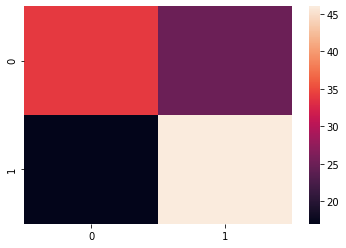

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
parameters = {'max_depth': [1, 5, 10, 100, None], 'max_features': [2, 3, 4]}
model_dt = GridSearchCV(DecisionTreeClassifier(), param_grid = parameters, cv = 5, n_jobs = -1)

# fit the classifier to the training data
model_dt.fit(trainX, trainY)

end = time.time()
print('Tuning Decision Tree Classifier took', end - start, 'seconds')

# find best hyperparameters
print(model_dt.best_estimator_)

# predict the labels of the test set
predictedY = model_dt.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

In [ ]:
bestDepth_DT_pca = 1
bestMaxFeatures_DT_pca = 2

Tuning Decision Tree Classifier took 0.19125938415527344 seconds
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.50      0.53      0.51        59
           1       0.53      0.51      0.52        63

    accuracy                           0.52       122
   macro avg       0.52      0.52      0.52       122
weighted avg       0.52      0.52      0.52       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

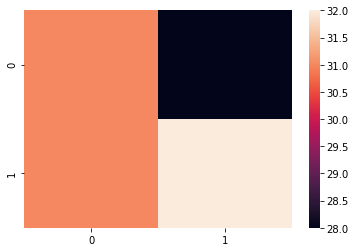

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
parameters = {'max_depth': [1, 5, 10, 100, None], 'max_features': [2, 3, 4]}
model_dt = GridSearchCV(DecisionTreeClassifier(), param_grid = parameters, cv = 5, n_jobs = -1)

# fit the classifier to the training data
model_dt.fit(trainX, trainY)

end = time.time()
print('Tuning Decision Tree Classifier took', end - start, 'seconds')

# find best hyperparameters
print(model_dt.best_estimator_)

# predict the labels of the test set
predictedY = model_dt.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

In [ ]:
bestDepth_DT_tsne = 10
bestMaxFeatures_DT_tsne = 2

### Random Forest Classifier

Tuning Random Forest took 0.183945894241333 seconds

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.87      0.76      0.81        59
           1       0.80      0.89      0.84        63

    accuracy                           0.83       122
   macro avg       0.83      0.83      0.83       122
weighted avg       0.83      0.83      0.83       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

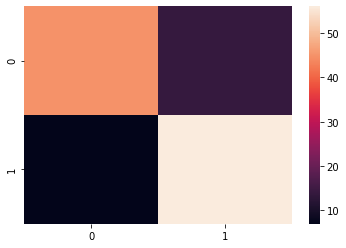

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
model_rf = RandomForestClassifier()

# fit the classifier to the training data
model_rf.fit(trainX, trainY)

end = time.time()
print('Tuning Random Forest took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_rf.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Tuning Random Forest took 0.18688273429870605 seconds

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.63      0.61      0.62        59
           1       0.65      0.67      0.66        63

    accuracy                           0.64       122
   macro avg       0.64      0.64      0.64       122
weighted avg       0.64      0.64      0.64       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

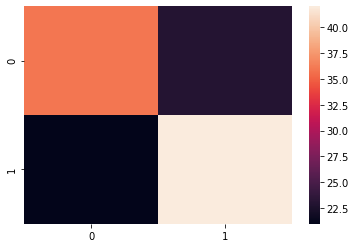

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
model_rf = RandomForestClassifier()

# fit the classifier to the training data
model_rf.fit(trainX, trainY)

end = time.time()
print('Tuning Random Forest took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_rf.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Tuning Random Forest took 0.17979192733764648 seconds

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.54      0.58      0.56        59
           1       0.58      0.54      0.56        63

    accuracy                           0.56       122
   macro avg       0.56      0.56      0.56       122
weighted avg       0.56      0.56      0.56       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

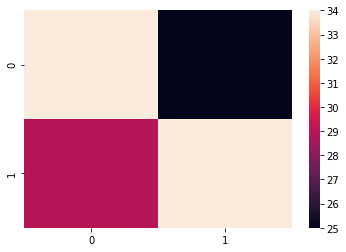

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
model_rf = RandomForestClassifier()

# fit the classifier to the training data
model_rf.fit(trainX, trainY)

end = time.time()
print('Tuning Random Forest took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_rf.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Tuning Random Forest took 65.74857091903687 seconds
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.82      0.80      0.81        59
           1       0.82      0.84      0.83        63

    accuracy                           0.82       122
   macro avg       0.82      0.82      0.82       122
weighted avg       0.82      0.82      0.82       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

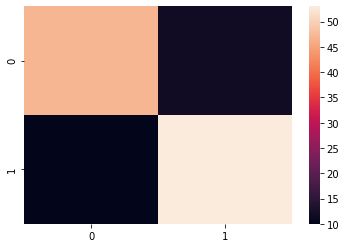

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
parameters = {'max_depth': [1, 5, 10, 100, None], 'max_features': [2, 3, 4], 'n_estimators': [100, 125, 150, 200]}
model_rf = GridSearchCV(RandomForestClassifier(), param_grid = parameters, cv = 5, n_jobs = -1)

# fit the classifier to the training data
model_rf.fit(trainX, trainY)

end = time.time()
print('Tuning Random Forest took', end - start, 'seconds')

# find best hyperparameters
print(model_rf.best_estimator_)

# predict the labels of the test set
predictedY = model_rf.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

In [ ]:
bestDepth_RF_original = 100
bestMaxFeatures_RF_original = 3
bestNumEstimators_RF_original = 150

Tuning Random Forest took 31.013280153274536 seconds
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.67      0.58      0.62        59
           1       0.65      0.73      0.69        63

    accuracy                           0.66       122
   macro avg       0.66      0.65      0.65       122
weighted avg       0.66      0.66      0.65       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

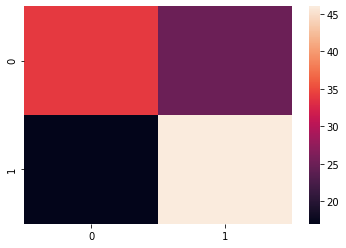

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
parameters = {'max_depth': [1, 5, 10, 100, None], 'max_features': [2, 3, 4], 'n_estimators': [50, 100, 150, 200]}
model_rf = GridSearchCV(RandomForestClassifier(), param_grid = parameters, cv = 5, n_jobs = -1)

# fit the classifier to the training data
model_rf.fit(trainX, trainY)

end = time.time()
print('Tuning Random Forest took', end - start, 'seconds')

# find best hyperparameters
print(model_rf.best_estimator_)

# predict the labels of the test set
predictedY = model_rf.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

In [ ]:
bestDepth_RF_pca = 1
bestMaxFeatures_RF_pca = 2
bestNumEstimators_RF_pca = 50

Tuning Random Forest took 45.614232301712036 seconds
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.58      0.58      0.58        59
           1       0.60      0.60      0.60        63

    accuracy                           0.59       122
   macro avg       0.59      0.59      0.59       122
weighted avg       0.59      0.59      0.59       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

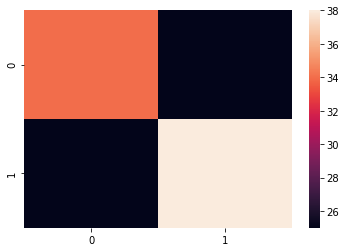

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
parameters = {'max_depth': [1, 5, 10, 100, None], 'max_features': [2, 3, 4], 'n_estimators': [50, 100, 150, 200]}
model_rf = GridSearchCV(RandomForestClassifier(), param_grid = parameters, cv = 5, n_jobs = -1)

# fit the classifier to the training data
model_rf.fit(trainX, trainY)

end = time.time()
print('Tuning Random Forest took', end - start, 'seconds')

# find best hyperparameters
print(model_rf.best_estimator_)

# predict the labels of the test set
predictedY = model_rf.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

In [ ]:
bestDepth_RF_tsne = 100
bestMaxFeatures_RF_tsne = 2
bestNumEstimators_RF_tsne = 150

### XGBoost Classifier


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.80      0.81      0.81        59
           1       0.82      0.81      0.82        63

    accuracy                           0.81       122
   macro avg       0.81      0.81      0.81       122
weighted avg       0.81      0.81      0.81       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

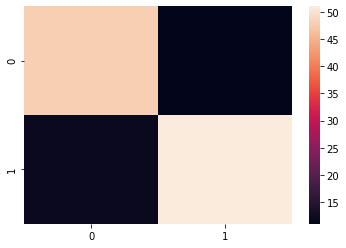

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.4, random_state = 0)

# set parameter values and grid search for optimal parameters
model_xgb = XGBClassifier(n_jobs = -1, eval_metric='mlogloss')

# fit the classifier to the training data
model_xgb.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_xgb.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.67      0.58      0.62        59
           1       0.65      0.73      0.69        63

    accuracy                           0.66       122
   macro avg       0.66      0.65      0.65       122
weighted avg       0.66      0.66      0.65       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

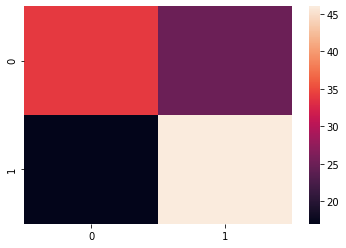

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

# set parameter values and grid search for optimal parameters
model_xgb = XGBClassifier(n_jobs = -1, eval_metric='mlogloss')

# fit the classifier to the training data
model_xgb.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_xgb.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.55      0.59      0.57        59
           1       0.59      0.54      0.56        63

    accuracy                           0.57       122
   macro avg       0.57      0.57      0.57       122
weighted avg       0.57      0.57      0.57       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

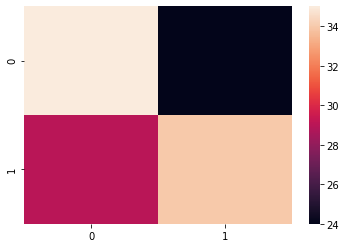

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

# set parameter values and grid search for optimal parameters
model_xgb = XGBClassifier(n_jobs = -1, eval_metric='mlogloss')

# fit the classifier to the training data
model_xgb.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_xgb.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0.001, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.81      0.81      0.81        59
           1       0.83      0.83      0.83        63

    accuracy                           0.82       122
   macro avg       0.82      0.82      0.82       122
weighted avg       0.82      0.82      0.82       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

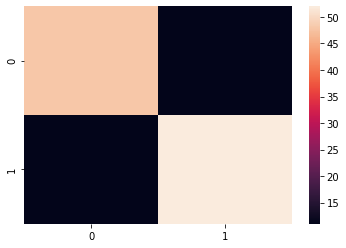

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.4, random_state = 0)

# set parameter values and grid search for optimal parameters
parameters = {'max_depth': [1, 5, 10, 100, None], 'reg_lambda': [0.001, 0.01, 0.1, 1, 10]}
model_xgb = GridSearchCV(XGBClassifier(n_jobs = -1, eval_metric='mlogloss'), parameters, cv = 5, n_jobs = -1)

# fit the classifier to the training data
model_xgb.fit(trainX, trainY)

# find best hyperparameters
print(model_xgb.best_estimator_)

# predict the labels of the test set
predictedY = model_xgb.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

In [ ]:
bestDepth_XGB_original = 1
bestRegLambda_XGB_original = 0.001

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.67      0.58      0.62        59
           1       0.65      0.73      0.69        63

    accuracy                           0.66       122
   macro avg       0.66      0.65      0.65       122
weighted avg       0.66      0.66      0.65       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

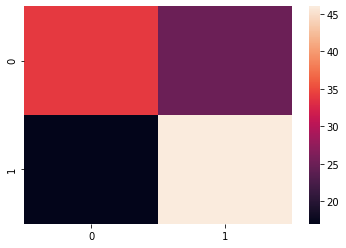

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

# set parameter values and grid search for optimal parameters
parameters = {'max_depth': [1, 5, 10, 100, None], 'reg_lambda': [0.001, 0.01, 0.1, 1, 10]}
model_xgb = GridSearchCV(XGBClassifier(n_jobs = -1, eval_metric='mlogloss'), parameters, cv = 5, n_jobs = -1)

# fit the classifier to the training data
model_xgb.fit(trainX, trainY)

# find best hyperparameters
print(model_xgb.best_estimator_)

# predict the labels of the test set
predictedY = model_xgb.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

In [ ]:
bestDepth_XGB_pca = 1
bestRegLambda_XGB_pca = 10

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=100,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0.001, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.54      0.58      0.56        59
           1       0.58      0.54      0.56        63

    accuracy                           0.56       122
   macro avg       0.56      0.56      0.56       122
weighted avg       0.56      0.56      0.56       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

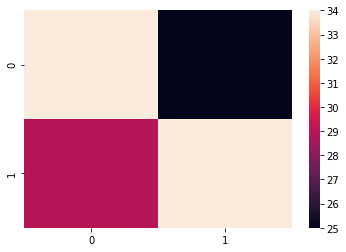

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

# set parameter values and grid search for optimal parameters
parameters = {'max_depth': [1, 5, 10, 100, None], 'reg_lambda': [0.001, 0.01, 0.1, 1, 10]}
model_xgb = GridSearchCV(XGBClassifier(n_jobs = -1, eval_metric='mlogloss'), parameters, cv = 5, n_jobs = -1)

# fit the classifier to the training data
model_xgb.fit(trainX, trainY)

# find best hyperparameters
print(model_xgb.best_estimator_)

# predict the labels of the test set
predictedY = model_xgb.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

In [ ]:
bestDepth_XGB_tsne = 100
bestRegLambda_XGB_tsne = 0.001

## Feature Importance

### Logistic Regression

Tuning Logistic Regression Model took 0.0668802261352539 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.85      0.78      0.81        59
           1       0.81      0.87      0.84        63

    accuracy                           0.83       122
   macro avg       0.83      0.83      0.83       122
weighted avg       0.83      0.83      0.83       122


Confusion Matrix:



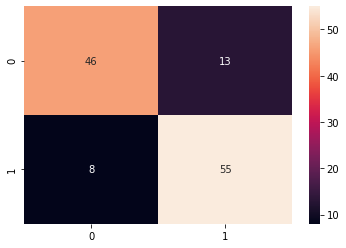

In [ ]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time() # time how long it takes to find the model

# create model
model_lr = LogisticRegression(C = bestC_original[0], max_iter = 10000)
model_lr.fit(trainX, trainY)

end = time.time()
print('Tuning Logistic Regression Model took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_lr.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

feature importance

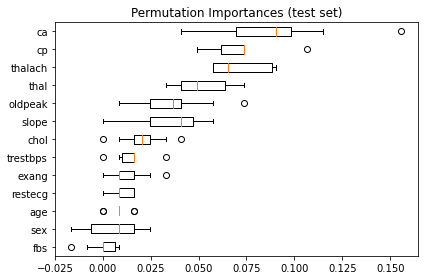

In [ ]:
result = permutation_importance(model_lr, testX, testY, n_repeats = 10, n_jobs = -1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert = False, labels = np.array(names[sorted_idx]))
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

### k-Nearest Neighbor Classifier (KNN)


Classification Report:

               precision    recall  f1-score   support

           0       0.68      0.68      0.68        59
           1       0.70      0.70      0.70        63

    accuracy                           0.69       122
   macro avg       0.69      0.69      0.69       122
weighted avg       0.69      0.69      0.69       122


Test Confusion Matrix:



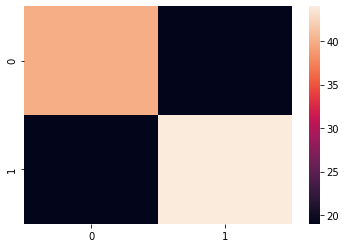

In [ ]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

# build the knn classifier
model_knn = KNeighborsClassifier(6)

# fit the knn classifier to the training data
model_knn.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_knn.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nTest Confusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY))

feature importance

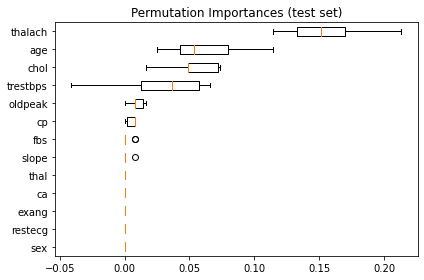

In [ ]:
result = permutation_importance(model_knn, testX, testY, n_repeats = 10, n_jobs = -1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert = False, labels = np.array(names[sorted_idx]))
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

### Linear Discriminant Analysis (LDA)

Running LDA took 0.005413055419921875 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.85      0.69      0.77        59
           1       0.76      0.89      0.82        63

    accuracy                           0.80       122
   macro avg       0.81      0.79      0.79       122
weighted avg       0.80      0.80      0.79       122


Confusion Matrix:



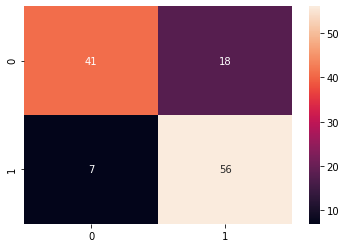

In [ ]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build the LDA classifier
model_lda = LinearDiscriminantAnalysis()

# fit the LDA classifier to the training data
model_lda.fit(trainX, trainY)

end = time.time()
print('Running LDA took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_lda.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

feature importance

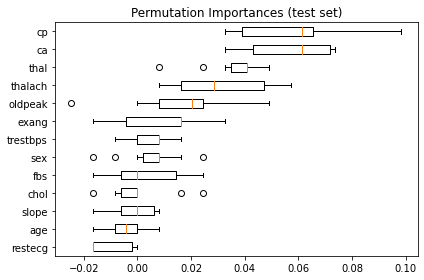

In [ ]:
result = permutation_importance(model_lda, testX, testY, n_repeats = 10, n_jobs = -1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert = False, labels = np.array(names[sorted_idx]))
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

### Quadratic Discriminant Analysis (QDA)

Running QDA took 0.0020956993103027344 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.86      0.71      0.78        59
           1       0.77      0.89      0.82        63

    accuracy                           0.80       122
   macro avg       0.81      0.80      0.80       122
weighted avg       0.81      0.80      0.80       122


Confusion Matrix:



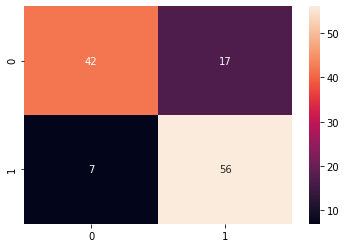

In [ ]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build the LDA classifier
model_qda = QuadraticDiscriminantAnalysis(reg_param = bestAccuracy_qda_o[1])

# fit the LDA classifier to the training data
model_qda.fit(trainX, trainY)

end = time.time()
print('Running QDA took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_qda.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

feature importance

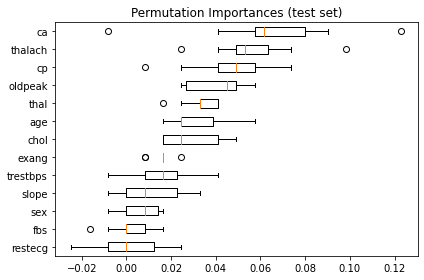

In [ ]:
result = permutation_importance(model_qda, testX, testY, n_repeats = 10, n_jobs = -1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert = False, labels = np.array(names[sorted_idx]))
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

### Decision Tree Classifier

Tuning Decision Tree Classifier took 0.001215219497680664 seconds

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.63      0.53      0.57        59
           1       0.62      0.71      0.66        63

    accuracy                           0.62       122
   macro avg       0.62      0.62      0.62       122
weighted avg       0.62      0.62      0.62       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

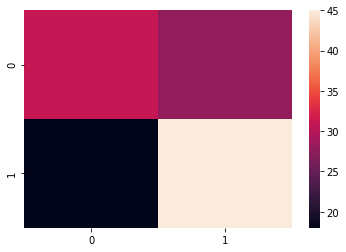

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
model_dt = DecisionTreeClassifier(max_depth = bestDepth_DT_original, max_features = bestMaxFeatures_DT_original)

# fit the classifier to the training data
model_dt.fit(trainX, trainY)

end = time.time()
print('Tuning Decision Tree Classifier took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_dt.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

feature importance

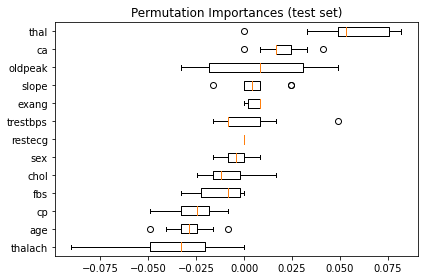

In [ ]:
result = permutation_importance(model_dt, testX, testY, n_repeats = 10, n_jobs = -1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert = False, labels = np.array(names[sorted_idx]))
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

### Random Forest Classifier

Tuning Random Forest took 0.2580130100250244 seconds

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.83      0.75      0.79        59
           1       0.78      0.86      0.82        63

    accuracy                           0.80       122
   macro avg       0.81      0.80      0.80       122
weighted avg       0.81      0.80      0.80       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

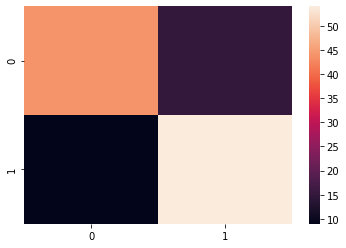

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
model_rf = RandomForestClassifier(max_depth = bestDepth_RF_original, max_features = bestMaxFeatures_RF_original, n_estimators = bestNumEstimators_RF_original)

# fit the classifier to the training data
model_rf.fit(trainX, trainY)

end = time.time()
print('Tuning Random Forest took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_rf.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

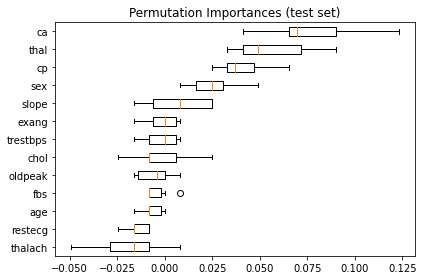

In [ ]:
result = permutation_importance(model_rf, testX, testY, n_repeats = 10, n_jobs = -1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert = False, labels = np.array(names[sorted_idx]))
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

### XGBoost Classifier


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.81      0.81      0.81        59
           1       0.83      0.83      0.83        63

    accuracy                           0.82       122
   macro avg       0.82      0.82      0.82       122
weighted avg       0.82      0.82      0.82       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

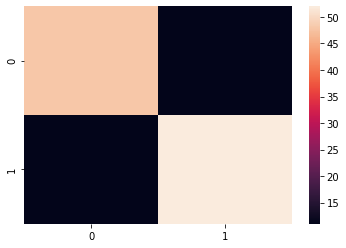

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.4, random_state = 0)

# set parameter values and grid search for optimal parameters
model_xgb = XGBClassifier(max_depth = bestDepth_XGB_original, reg_lambda = bestRegLambda_XGB_original, n_jobs = -1, eval_metric='mlogloss')

# fit the classifier to the training data
model_xgb.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_xgb.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

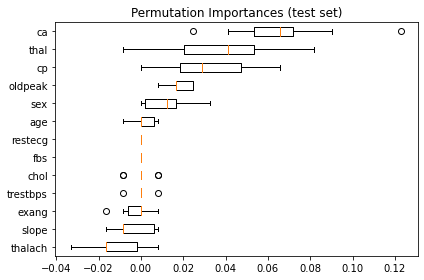

In [ ]:
result = permutation_importance(model_xgb, testX, testY, n_repeats = 10, n_jobs = -1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert = False, labels = np.array(names[sorted_idx]))
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## Clustering

In [ ]:
sklearn.clustering.DBSCAN
sklearn.clustering.OPTICS


## Conclusions